In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

%matplotlib inline

# 1. Problems with comparing Gram matrices

The style-loss function employed in [Gatys et al](https://arxiv.org/abs/1508.06576) is the sum of the squares (or squared Froebenius norm) of the differences of Gram matrices of the activations enduced by the style image and the subject/synthesized image in the feature space of a given layer of the network.  

A [Gram matrix](https://en.wikipedia.org/wiki/Gramian_matrix) is a non-central second moment. The example below is designed to illustrate how variables can have different [central moments](https://en.wikipedia.org/wiki/Moment_(mathematics) (means and covariances) but identical Gram matrices. 

Consider two [multivariate guassian](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) random vectors, X and Y, in three dimensional Euclidean space with means and covariances (central moments) specified:

In [2]:
mean_X = np.array([[0.0,-0.5,0.5]])
corr_X = np.array([[1.,-.5,0.],[-.5,1.,0.],[0.,0.,1.]])
sigma_X = np.array([[1., 1., 1.]])
cov_X = sigma_X.T*corr_X*sigma_X #covariance matrix derived from corr and sigma to ensure positive semi-definite

mean_Y = np.array([[1.,-.5,0.]])
corr_Y = np.array([[1.,0.,-.5],[0.,1.,-.25/np.sqrt(1.25)],[-.5,-.25/np.sqrt(1.25),1.]])
sigma_Y = np.array([[0, 1., np.sqrt(1.25)]])
cov_Y = sigma_Y.T*corr_Y*sigma_Y

### Lets generate random samples from these distributions and plot them in RGB space:

5 samples of X: 
 [[ 1.09023702 -0.65989525  0.62671565]
 [ 1.65052411 -1.53607747 -0.05604886]
 [ 1.9735886  -1.90385998  3.00659452]
 [-0.84796551  0.26014013  2.52513163]
 [-0.39932609 -1.02251608 -1.10496079]] 
 
 5 samples of Y: 
 [[ 1.         -1.14871992  1.3497165 ]
 [ 1.          0.0364237   0.00707374]
 [ 1.         -2.1070868   0.11619713]
 [ 1.         -1.41479725  0.28771887]
 [ 1.         -0.15351611 -1.94316   ]] 



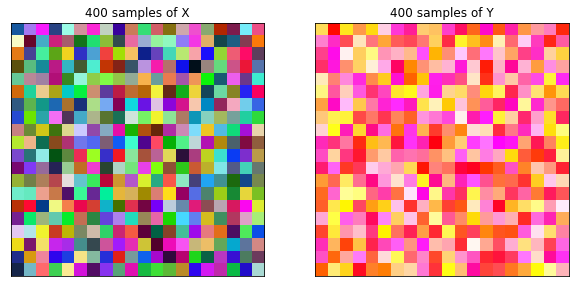

In [3]:
samples_X = np.random.multivariate_normal(mean_X[0], cov_X, 10000)
samples_Y = np.random.multivariate_normal(mean_Y[0], cov_Y, 10000)

print("5 samples of X:", "\n", samples_X[:5], "\n \n", "5 samples of Y:", "\n", samples_Y[:5], "\n")

fig, axes = plt.subplots(1, 2, figsize=(10, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

axes[0].set_title('400 samples of X')
axes[0].imshow(samples_X[:400].reshape((20,20,3)))

axes[1].set_title('400 samples of Y')
axes[1].imshow(samples_Y[:400].reshape((20,20,3)))


### And calculate the observed Gram matrices over 10,000 samples:

In [4]:
gram_X = np.matmul(samples_X.T, samples_X)/samples_X.shape[0]
gram_Y = np.matmul(samples_Y.T, samples_Y)/samples_Y.shape[0]

np.set_printoptions(precision=5)

print("Observed Gram matrix of X:", "\n", gram_X, "\n")

print("Observed Gram matrix of Y:", "\n", gram_Y, "\n")

print("Squared difference of observed Gram matrices:", np.sum((gram_X-gram_Y)**2))



Observed Gram matrix of X: 
 [[  1.00512e+00  -5.20003e-01  -5.09802e-05]
 [ -5.20003e-01   1.26724e+00  -2.49250e-01]
 [ -5.09802e-05  -2.49250e-01   1.23205e+00]] 

Observed Gram matrix of Y: 
 [[ 1.      -0.48827  0.00373]
 [-0.48827  1.23418 -0.23555]
 [ 0.00373 -0.23555  1.2431 ]] 

Squared difference of observed Gram matrices: 0.00365975769186


### The style-loss function used in Gatys et al. would see these random vectors as identical (to some precision). 

Yet, visually they are very different. This is because the sum of squared differences of Gram matrices is not a valid metric on random vectors with non-zero means and non-zero central second moments. Here, the [Identity of Indiscernibles](https://en.wikipedia.org/wiki/Identity_of_indiscernibles) is violated.

# 2. Wasserstein/Earth Mover's Distance is a valid metric.

There is a headache, however, in that calculating it becomes computationally huge:

In [5]:
n_pixels = 224*224 #or n_samples
n_features = 64

distance_matrix_size = ((n_pixels)**2)*(32/8)/(10**9)
tflops_per_evaulation = (n_pixels)**3/(10**12)

print("To calculate non-parametric Wasserstein/Earth Mover's Distance:")
print("Distance matrix size for float32: {:4.1f} gb".format(distance_matrix_size))
print("Once have dist matrix, to calc EMD: {:4.1f} TFLOPS".format(tflops_per_evaulation))

To calculate non-parametric Wasserstein/Earth Mover's Distance:
Distance matrix size for float32: 10.1 gb
Once have dist matrix, to calc EMD: 126.3 TFLOPS


We can simplify this greatly by assuming our distributions are fully characterized by their respective first 2 central moments (or in other words, they are Multivariate Gaussians, symmetric about means with ellipsoid equi-density contours).  This gives us a [closed form calculation](https://projecteuclid.org/download/pdf_1/euclid.mmj/1029003026) that is readily computable. 

In [6]:
def wdist_gaussian(m1, cov1, m2, cov2): 
  mean_diff = np.sum((m1-m2)**2)
  var_components = np.trace(cov1+cov2)
  #need to round to prevent eigenvalues very close to zero from becoming negative
  var_overlap = np.sum(np.sqrt(np.round(np.linalg.eigvals(np.matmul(cov1,cov2)),5)))
  
  return  np.sqrt(mean_diff+var_components-2*var_overlap)


In [7]:
wdist_gaussian(mean_X, cov_X, mean_Y, cov_Y)

1.5135220191046239

### This loss formulation is not perfect for all situations

It requires assuming the random vectors are Gaussian which may not be appropriate when distributions are heavily skewed in some dimensions. In practice it seems to work quite well for style transfer. 